In [1]:
KERNEL_LAUNCH_TIMEOUT = 100

In [2]:
import pandas as pd
from PIL import Image
import numpy as np
import glob
from sklearn.model_selection import train_test_split
from functools import partial

from torchvision.models import resnet18
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torch.nn import Linear, Conv2d, Module, Flatten, Softmax, CrossEntropyLoss, MaxPool2d, AvgPool2d, Dropout, BatchNorm2d, ReLU, AdaptiveAvgPool2d
from torch.nn.utils import clip_grad_norm
from torch.optim import Adam, SGD
from torch import tensor, from_numpy, argmax, BoolStorage, concat
import torch
from tfrecord.torch.dataset import TFRecordDataset
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from tqdm import tqdm

EPOCHS = 20
BATCH_SIZE = 20

/home/cameron/anaconda3/envs/selfie/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
reference_map = pd.read_csv("./chinese_mnist.csv")

In [5]:
def collate(preprocess, batch):
    images = None
    labels = None
    for data in batch:
        proc_im = preprocess(data["images"])
        image = tensor(proc_im).reshape((1, 1, 224, 224)).cuda()
        label = tensor(data["labels"]).cuda()
        if images == None:
            images = image
            labels = label
        else:
            images = torch.cat((images, image), 0)
            labels = torch.cat((labels, label), 0)
    return images, labels

In [6]:
preprocess = transforms.Compose([
            transforms.Resize(264),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize((0.5), (0.5)),
            #transforms.Grayscale()
        ])
#dataset = TFRecordDataset("./chinese_mnist.tfrecords", None, None)
dataset = { "images": [], "labels": [] }
for data in glob.glob("./data/data/*"):
    img = Image.open(data)
    dataset["images"].append(img)
    codes = data.split("_")
    suite_id, sample_id, code = int(codes[1]), int(codes[2]), codes[3]
    code = int(code.split(".")[0]) - 1
    dataset["labels"].append([code])
data = pd.DataFrame(data = dataset)
train_data, val_data = train_test_split(data, test_size = 0.2, train_size=0.8, random_state=225, shuffle=True)
train_data.reset_index(drop=True, inplace=True)
val_data.reset_index(drop=True, inplace=True)

In [7]:
class ImageDataset(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        return self.df.iloc[index]
train_dataset = ImageDataset(train_data)
val_dataset = ImageDataset(val_data)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=partial(collate, preprocess), shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=partial(collate, preprocess), shuffle=True, drop_last=True)

In [8]:
class ResNetBlock(Module):
    def __init__(self, in_channel_size, hidden_channel_size, stride=1):
        super(ResNetBlock, self).__init__()
        self.stride = stride
        self.conv1 = Conv2d(in_channel_size, hidden_channel_size, 3, stride=stride, dilation=stride, padding=stride)
        self.conv2 = Conv2d(hidden_channel_size, hidden_channel_size, 3, dilation=stride, padding=stride)
        self.conv_d = Conv2d(in_channel_size, hidden_channel_size, 3, stride=stride, dilation=stride, padding=stride)
        self.batchnorm = BatchNorm2d(hidden_channel_size)
        self.batchnorm2 = BatchNorm2d(hidden_channel_size)
        self.batchnorm3 = BatchNorm2d(hidden_channel_size)
        self.relu = ReLU(inplace=True)

    def forward(self, input):
        identity = input
        x = self.relu(self.batchnorm(self.conv1(input)))
        x = self.batchnorm2(self.conv2(x))
        if self.stride != 1:
            identity = self.batchnorm3(self.conv_d(identity))
        x += identity
        return self.relu(x)

In [9]:
class GestureNN(Module):
    def __init__(self):
        super(GestureNN, self).__init__()
        self.dropout = Dropout(0.1)
        self.res_block = ResNetBlock(120, 120)
        self.res_block2 = ResNetBlock(120, 128, stride=2)
        self.res_block3 = ResNetBlock(128, 256, stride=2)
        self.res_block4 = ResNetBlock(256, 512, stride=2)
        self.relu = ReLU(inplace=True)
        self.pool = AvgPool2d(2,2)

        self.conv1_1 = Conv2d(1, 20, 2)
        self.conv1_2 = Conv2d(20, 20, 2)
        self.conv1_3 = Conv2d(20, 20, 2)
        self.batch_norm1 = BatchNorm2d(20)
        self.pool1 = AvgPool2d(2,2)

        self.conv2_1 = Conv2d(20, 40, 2)
        self.conv2_2 = Conv2d(40, 40, 2)
        self.conv2_3 = Conv2d(40, 40, 2)
        self.batch_norm2 = BatchNorm2d(40)
        self.pool2 = AvgPool2d(2,2)

        self.conv3_1 = Conv2d(40, 80, 1)
        self.conv3_2_a = Conv2d(40, 40, 1)
        self.conv3_2_b = Conv2d(40, 40, 3, padding=1)
        self.conv3_3 = Conv2d(80, 80, 2)
        self.batch_norm3 = BatchNorm2d(120)
        self.pool3 = AvgPool2d(2,2)

        self.adpool = AdaptiveAvgPool2d(1)
        self.flatten = Flatten()
        self.linear1 = Linear(2048, 15)

    def forward(self, input):
        x = self.conv1_1(input)
        x = self.conv1_2(x)
        x = self.conv1_3(x)
        x = self.pool1(x)
        x = self.batch_norm1(x)
        x = self.relu(x)

        x = self.conv2_1(x)
        x = self.conv2_2(x)
        x = self.conv2_3(x)
        x = self.pool2(x)
        x = self.batch_norm2(x)
        x = self.relu(x)

        x1 = self.conv3_1(x)
        x2_a = self.conv3_2_a(x)
        x2_b = self.conv3_2_b(x2_a)
        x = concat((x1, x2_b), dim=1)
        x = self.pool3(x)
        x = self.batch_norm3(x)
        x = self.relu(x)

        x = self.res_block(x)
        x = self.res_block2(x)
        x = self.res_block3(x)
        x = self.res_block4(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.linear1(x)
        return x

# model = resnet18(pretrained=False)
# model.conv1 = Conv2d(1, 64, 7, 2)
# num_in_features = model.fc.in_features
# model.fc = Linear(num_in_features, 15)
model = GestureNN()
criterion = CrossEntropyLoss()
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
optimizer = Adam(params=model.parameters(), lr=0.02)
#optimizer = SGD(params=model.parameters(), lr=0.07, momentum=0.9)

In [10]:
# class GestureNN(Module):
#     def __init__(self):
#         super(GestureNN, self).__init__()
#         self.dropout = Dropout(0.1)
#         self.res_block = ResNetBlock(80, 80)
#         self.res_block2 = ResNetBlock(80, 128, stride=2)
#         self.res_block3 = ResNetBlock(128, 256, stride=2)
#         self.res_block4 = ResNetBlock(256, 512, stride=2)
#         self.relu = ReLU(inplace=True)
#         self.pool = AvgPool2d(2,2)

#         self.conv1_1 = Conv2d(1, 20, 2)
#         self.conv1_2 = Conv2d(20, 20, 2)
#         self.conv1_3 = Conv2d(20, 20, 2)
#         self.batch_norm1 = BatchNorm2d(20)
#         self.pool1 = AvgPool2d(2,2)

#         self.conv2_1 = Conv2d(20, 40, 2)
#         self.conv2_2 = Conv2d(40, 40, 2)
#         self.conv2_3 = Conv2d(40, 40, 2)
#         self.batch_norm2 = BatchNorm2d(40)
#         self.pool2 = AvgPool2d(2,2)

#         self.conv3_1 = Conv2d(40, 80, 2)
#         self.conv3_2 = Conv2d(80, 80, 2)
#         self.conv3_3 = Conv2d(80, 80, 2)
#         self.batch_norm3 = BatchNorm2d(80)
#         self.pool3 = AvgPool2d(2,2)

#         self.adpool = AdaptiveAvgPool2d(1)
#         self.flatten = Flatten()
#         self.linear1 = Linear(2048, 15)

#     def forward(self, input):
#         x = self.conv1_1(input)
#         x = self.conv1_2(x)
#         x = self.conv1_3(x)
#         x = self.pool1(x)
#         x = self.batch_norm1(x)
#         x = self.relu(x)

#         x = self.conv2_1(x)
#         x = self.conv2_2(x)
#         x = self.conv2_3(x)
#         x = self.pool2(x)
#         x = self.batch_norm2(x)
#         x = self.relu(x)

#         x = self.conv3_1(x)
#         x = self.conv3_2(x)
#         x = self.conv3_3(x)
#         x = self.pool3(x)
#         x = self.batch_norm3(x)
#         x = self.relu(x)

#         x = self.res_block(x)
#         x = self.res_block2(x)
#         x = self.res_block3(x)
#         x = self.res_block4(x)
#         x = self.pool(x)
#         x = self.flatten(x)
#         x = self.linear1(x)
#         return x

# # model = resnet18(pretrained=False)
# # model.conv1 = Conv2d(1, 64, 7, 2)
# # num_in_features = model.fc.in_features
# # model.fc = Linear(num_in_features, 15)
# model = GestureNN()
# criterion = CrossEntropyLoss()
# if torch.cuda.is_available():
#     model = model.cuda()
#     criterion = criterion.cuda()
# optimizer = Adam(params=model.parameters(), lr=0.02)
# #optimizer = SGD(params=model.parameters(), lr=0.07, momentum=0.9)

In [11]:
def test(model, glob_acc):
    val_loss = []
    acc = 0
    for images, labels in val_loader:
        images.cuda()
        labels.cuda()
        output = model(images)
        loss = criterion(output, labels)
        acc += sum((argmax(output, 1) == labels).int())
        val_loss.append(loss.item())
    print(f"Val loss: {sum(val_loss)/len(val_loader.dataset)}")
    print(f"Val accuracy: {acc/len(val_loader.dataset)}")
    glob_acc.append(acc.cpu()/len(val_loader.dataset))

In [12]:

total_acc = []
test_acc = []
for i in range(EPOCHS):
    print(f"Epoch: {i}")
    train_loss = 0
    for images, labels in train_loader:
        acc = 0
        optimizer.zero_grad()
        images.cuda()
        labels.cuda()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        # clip_grad_norm(model.parameters(), 10)
        optimizer.step()
        acc += sum((argmax(output, 1) == labels).int())
        train_loss += loss.item()

    print(f"Train loss: {train_loss/BATCH_SIZE}")
    print(f"Train accuracy: {acc/BATCH_SIZE}")
    total_acc.append(acc.cpu()/BATCH_SIZE)
    test(model, test_acc)

Epoch: 0


/tmp/ipykernel_39508/3465878215.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = tensor(proc_im).reshape((1, 1, 224, 224)).cuda()


Train loss: 43.5408107008785
Train accuracy: 0.8500000238418579
Val loss: 0.018544500554601353
Val accuracy: 0.8799999952316284
Epoch: 1
Train loss: 9.267080155853183
Train accuracy: 1.0
Val loss: 0.013537500827262799
Val accuracy: 0.9123333096504211
Epoch: 2
Train loss: 5.096494273236021
Train accuracy: 1.0
Val loss: 0.006565515476589402
Val accuracy: 0.9666666388511658
Epoch: 3
Train loss: 3.2973274181626038
Train accuracy: 0.949999988079071
Val loss: 0.006925140885655613
Val accuracy: 0.9623333215713501
Epoch: 4
Train loss: 3.044804785541783
Train accuracy: 0.949999988079071
Val loss: 0.004518128397632003
Val accuracy: 0.9769999980926514
Epoch: 5
Train loss: 2.479145776498626
Train accuracy: 1.0
Val loss: 0.005037042240456989
Val accuracy: 0.9713333249092102
Epoch: 6
Train loss: 2.3389320137677716
Train accuracy: 1.0
Val loss: 0.00431956557170876
Val accuracy: 0.9789999723434448
Epoch: 7
Train loss: 2.076483569707034
Train accuracy: 1.0
Val loss: 0.006255038146240016
Val accuracy: 0

In [13]:
def plot_grad_flow(named_parameters):
    '''Plots the gradients flowing through different layers in the net during training.
    Can be used for checking for possible gradient vanishing / exploding problems.
    
    Usage: Plug this function in Trainer class after loss.backwards() as 
    "plot_grad_flow(self.model.named_parameters())" to visualize the gradient flow'''
    ave_grads = []
    max_grads= []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            if p.grad == None:
                layers.append(n)
                ave_grads.append(0)
                max_grads.append(0)
            else:
                layers.append(n)
                ave_grads.append(p.grad.abs().mean())
                max_grads.append(p.grad.abs().max())
    plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.1, lw=1, color="c")
    plt.bar(np.arange(len(max_grads)), ave_grads, alpha=0.1, lw=1, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, lw=2, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(left=0, right=len(ave_grads))
    plt.ylim(bottom = -0.001, top=0.02) # zoom in on the lower gradient regions
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.legend([Line2D([0], [0], color="c", lw=4),
                Line2D([0], [0], color="b", lw=4),
                Line2D([0], [0], color="k", lw=4)], ['max-gradient', 'mean-gradient', 'zero-gradient'])

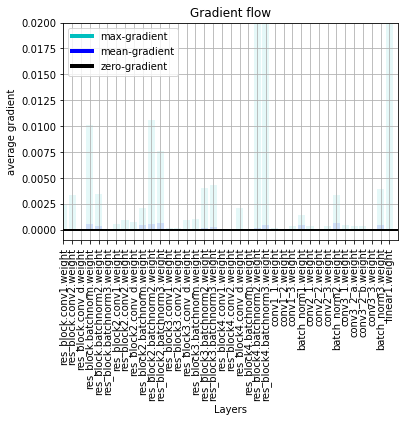

In [14]:
model = model.cpu()
plot_grad_flow(model.named_parameters())

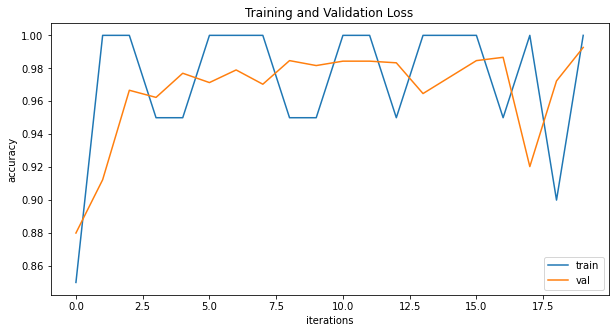

In [15]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(total_acc,label="train")
plt.plot(test_acc,label="val")
plt.xlabel("iterations")
plt.ylabel("accuracy")
plt.legend()
plt.show()